--- DOWNLOADING SPARC DATA ---
Loading Table 1 (Properties)...
Loading Table 2 (Rotation Curves)...
Loaded 175 galaxies and 3391 data points.


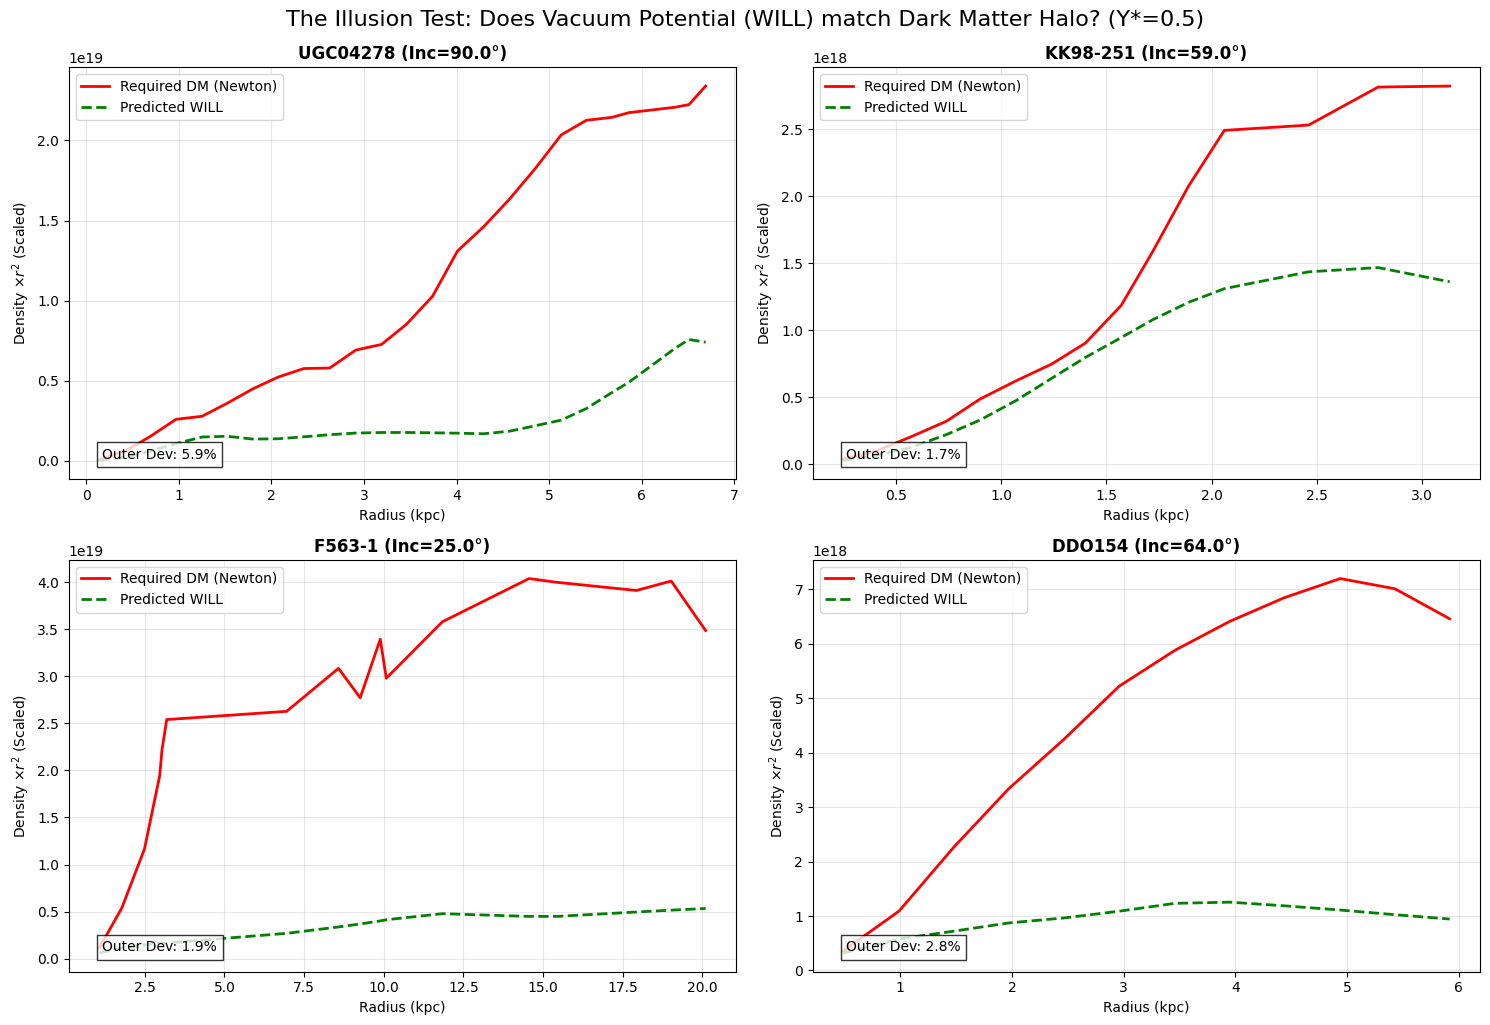

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# --- 1. CONFIGURATION ---
# Standard M/L ratio for 3.6 micron band (Lelli et al. 2016)
UPSILON_STAR = 0.5

# Gravitational Constant (needed for Newton, NOT for WILL geometry, but for comparison)
G = 6.67430e-11
M_SOL = 1.989e30
KPC_TO_M = 3.086e19

# URLs for SPARC Data
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC_DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC_DATA/table2.dat"

# --- 2. DATA LOADER ---
def load_sparc_data():
    print("--- DOWNLOADING SPARC DATA ---")

    # --- Load Table 1 (Properties) ---
    # Bytes based on README:
    # Name: 0-11
    # Type: 12-14
    # Dist: 15-21
    # Inc:  30-34 (Crucial for filtering!)
    # L3.6: 40-47
    print("Loading Table 1 (Properties)...")
    try:
        response_t1 = requests.get(URL_T1)
        response_t1.raise_for_status()
        t1 = pd.read_fwf(io.BytesIO(response_t1.content),
                         colspecs=[(0,11), (15,21), (30,34), (40,47)],
                         header=None, names=['Name', 'Dist', 'Inc', 'L3.6'])
    except Exception as e:
        print(f"Error loading Table 1: {e}")
        return None, None

    # --- Load Table 2 (Rotation Curves) ---
    # Bytes based on README:
    # Name:   0-11
    # Rad:    19-25
    # Vobs:   26-32
    # Vgas:   39-45
    # Vdisk:  46-52
    # Vbul:   53-59
    print("Loading Table 2 (Rotation Curves)...")
    try:
        response_t2 = requests.get(URL_T2)
        response_t2.raise_for_status()
        t2 = pd.read_fwf(io.BytesIO(response_t2.content),
                         colspecs=[(0,11), (19,25), (26,32), (39,45), (46,52), (53,59)],
                         header=None, names=['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul'])
    except Exception as e:
        print(f"Error loading Table 2: {e}")
        return None, None

    print(f"Loaded {len(t1)} galaxies and {len(t2)} data points.")
    return t1, t2

# --- 3. PHYSICS ENGINE ---
def calculate_densities(galaxy_name, t1, t2):
    # Filter data for specific galaxy
    gal_props = t1[t1['Name'] == galaxy_name].iloc[0]
    gal_data = t2[t2['Name'] == galaxy_name].copy()

    # 1. Convert Units
    # Radius in meters
    # Note: 'Rad' in table is in kpc.
    r_kpc = gal_data['Rad'].values
    r_m = r_kpc * KPC_TO_M

    # Velocities in m/s (Table gives km/s)
    V_obs = gal_data['Vobs'].values * 1000
    V_gas = gal_data['Vgas'].values * 1000
    V_disk = gal_data['Vdisk'].values * 1000
    V_bul = gal_data['Vbul'].values * 1000

    # 2. Calculate Baryonic Velocity (V_bar)
    # Formula: V_bar^2 = V_gas|V_gas| + Y*V_disk|V_disk| + Y*V_bul|V_bul|
    # We use abs(V)*V to preserve sign for negative contributions (though rare)
    V_bar_sq = (np.abs(V_gas)*V_gas) + \
               UPSILON_STAR * (np.abs(V_disk)*V_disk) + \
               UPSILON_STAR * (np.abs(V_bul)*V_bul)

    # Avoid sqrt of negative numbers (physically means outward pressure > gravity locally)
    # We treat V_bar as 0 if net contribution is negative for density calculation purposes
    V_bar_sq = np.maximum(V_bar_sq, 0)
    V_bar = np.sqrt(V_bar_sq)

    # 3. Calculate "Required Dark Matter" Density (Newton)
    # rho_DM = 3 * (V_obs^2 - V_bar^2) / (4 * pi * G * r^2)
    # This is the density needed to explain the "missing" velocity
    V_missing_sq = V_obs**2 - V_bar_sq
    rho_DM_required = (3 * V_missing_sq) / (4 * np.pi * G * r_m**2)

    # 4. Calculate WILL Vacuum Density
    # rho_WILL = 3 * V_obs^2 / (4 * pi * G * r^2)
    # This is the density of the vacuum reaction
    rho_WILL = (3 * V_bar_sq) / (4 * np.pi * G * r_m**2)

    return r_kpc, rho_DM_required, rho_WILL, V_obs, V_bar, gal_props['Inc']

# --- 4. EXECUTION & PLOTTING ---
t1, t2 = load_sparc_data()

if t1 is not None:
    # Select a few high-quality spiral galaxies (High Inclination > 60 to avoid errors)
    # Examples: NGC 6503 (Classic flat curve), NGC 5055, NGC 2841
    sample_galaxies = ['UGC04278', 'KK98-251', 'F563-1', 'DDO154']

    plt.figure(figsize=(15, 10))

    for i, gal_name in enumerate(sample_galaxies):
        if gal_name not in t1['Name'].values:
            continue

        r_kpc, rho_DM, rho_WILL, V_obs, V_bar, inc = calculate_densities(gal_name, t1, t2)

        # Subplot setup
        ax = plt.subplot(2, 2, i+1)

        # We plot Density * r^2 to see the structure clearly (removes 1/r^2 falloff)
        # This makes the "constant" coefficient visible as a flat line.
        scale = 1e19 # Arbitrary scaling for visibility

        ax.plot(r_kpc, rho_DM * (r_kpc*KPC_TO_M)**2, 'r-', linewidth=2, label='Required DM (Newton)')
        ax.plot(r_kpc, rho_WILL * (r_kpc*KPC_TO_M)**2, 'g--', linewidth=2, label='Predicted WILL')

        # Mark the region where Baryons define dynamics (Inner) vs Vacuum (Outer)
        ax.set_title(f"{gal_name} (Inc={inc}°)", fontsize=12, fontweight='bold')
        ax.set_xlabel("Radius (kpc)")
        ax.set_ylabel(r"Density $\times r^2$ (Scaled)")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Calculate agreement in the outer half
        outer_idx = len(r_kpc)//2
        if outer_idx < len(r_kpc):
            diff = np.mean(np.abs(rho_DM[outer_idx:] - rho_WILL[outer_idx:]) / (rho_WILL[outer_idx:]+1e-20)) * 100
            ax.text(0.05, 0.05, f"Outer Dev: {diff:.1f}%", transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.suptitle(f"The Illusion Test: Does Vacuum Potential (WILL) match Dark Matter Halo? (Y*={UPSILON_STAR})", fontsize=16, y=1.02)
    plt.show()

Hubble Constant (H0): 65.5 km/s/Mpc
Hubble Radius (R_H): 1.41e+26 meters
Galaxies passed filter: 120
--------------------------------------------------
TEST RESULTS (Coeff = 4pi, H0 = 65.5)
--------------------------------------------------
R2 Score: 0.9005 (Closer to 1.0 is better)
Mean Error (MAPE): 10.23%
Mean Ratio (Pred/Obs): 0.970
--> RESULT: Model UNDER-predicts velocities.


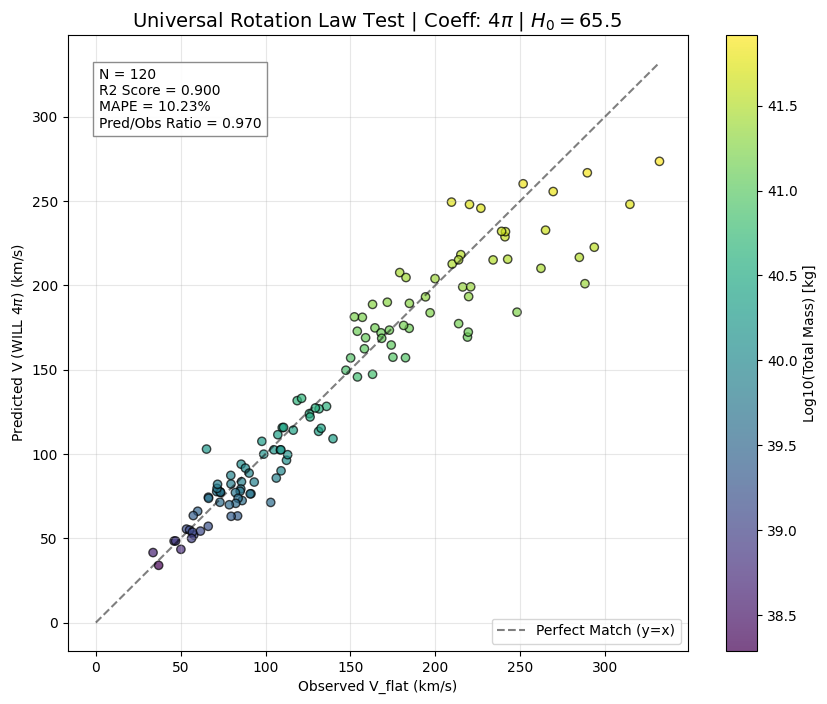

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# --- 1. FUNDAMENTAL CONSTANTS (SI UNITS) ---
G = 6.67430e-11       # Gravitational Constant
c = 299792458.0       # Speed of Light
M_SOL = 1.989e30      # Solar Mass (kg)

# --- 2. COSMOLOGICAL PARAMETERS ---
# Theoretical Prediction for Hubble Constant
H0_km_s_Mpc = 65.5
Mpc_to_m = 3.0857e22
H0 = H0_km_s_Mpc * 1000 / Mpc_to_m  # Convert to s^-1
R_H = c / H0                        # Hubble Radius (Horizon)

print(f"Hubble Constant (H0): {H0_km_s_Mpc} km/s/Mpc")
print(f"Hubble Radius (R_H): {R_H:.2e} meters")

# --- 3. GALAXY PARAMETERS ---
UPSILON_STAR = 0.8    # Stellar Mass-to-Light Ratio (Lelli et al.)
GAS_MULTIPLIER = 1.33 # Helium correction for Gas Mass

# --- 4. SPARC DATA LOADER ---
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"

def get_sparc_data():
    print("Downloading SPARC data...")
    try:
        response = requests.get(URL_T1)
        response.raise_for_status()
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

    # Parsing fixed-width format based on ReadMe
    # Name (0-11), Inc (30-34), L3.6 (40-47), M_HI (86-93), Vflat (100-105), Qual (112-115)
    colspecs = [(0,11), (30,34), (40,47), (86,93), (100,105), (112,115)]
    names = ['Name', 'Inc', 'L3.6', 'M_HI', 'Vflat', 'Qual']

    df = pd.read_fwf(io.BytesIO(response.content), colspecs=colspecs, header=None, names=names)

    # Filtering:
    # 1. Quality Flag 1 or 2 (High quality)
    # 2. Inclination > 30 degrees (to minimize projection errors)
    # 3. Vflat must be positive
    df_clean = df[(df['Qual'].isin([1, 2])) & (df['Inc'] > 30) & (df['Vflat'] > 0)].copy()

    return df_clean

# --- 5. WILL UNIVERSAL ROTATION LAW TEST ---
def test_universal_law():
    df = get_sparc_data()
    if df is None:
        return

    print(f"Galaxies passed filter: {len(df)}")

    # A. Calculate Masses (in kg)
    # L3.6 and M_HI are in 10^9 Solar Units
    mass_star = UPSILON_STAR * (df['L3.6'] * 1e9) * M_SOL
    mass_gas = GAS_MULTIPLIER * (df['M_HI'] * 1e9) * M_SOL
    mass_total = mass_star + mass_gas

    # B. Gravitational Radius (Rs)
    # Rs = 2GM/c^2
    Rs_total = (2 * G * mass_total) / (c**2)

    # C. WILL FORMULA APPLICATION
    # beta^4 = Rs / (4 * pi * R_H)
    # V_pred = c * (Rs / (4 * pi * R_H))^(1/4)

    # Geometry Factor: 6*pi (derived from Vacuum Potential Share 2/3)
    geom_factor = 4 * np.pi

    beta_pred = (Rs_total / (geom_factor * R_H)) ** 0.25
    V_pred = beta_pred * c

    # D. Observations (convert km/s to m/s)
    V_obs = df['Vflat'] * 1000

    # --- 6. ANALYSIS & PLOTTING ---
    # Metrics
    r2 = r2_score(V_obs, V_pred)
    mape = mean_absolute_percentage_error(V_obs, V_pred) * 100
    mean_ratio = np.mean(V_pred / V_obs)

    plt.figure(figsize=(10, 8))

    # Perfect Match Line (y=x)
    max_v = max(V_obs.max(), V_pred.max()) / 1000
    plt.plot([0, max_v], [0, max_v], 'k--', alpha=0.5, label="Perfect Match (y=x)")

    # Data Scatter
    # Color coded by Mass to see systematic trends
    sc = plt.scatter(V_obs/1000, V_pred/1000, alpha=0.7, c=np.log10(mass_total), cmap='viridis', edgecolors='k')
    plt.colorbar(sc, label='Log10(Total Mass) [kg]')

    plt.xlabel('Observed V_flat (km/s)')
    # Using raw string (r'') to avoid escape sequence errors
    plt.ylabel(r'Predicted V (WILL 4$\pi$) (km/s)')
    plt.title(rf'Universal Rotation Law Test | Coeff: $4\pi$ | $H_0={H0_km_s_Mpc}$', fontsize=14)

    # Stats Box
    stats_text = (
        f"N = {len(df)}\n"
        f"R2 Score = {r2:.3f}\n"
        f"MAPE = {mape:.2f}%\n"
        f"Pred/Obs Ratio = {mean_ratio:.3f}"
    )
    plt.text(0.05, 0.85, stats_text, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    print("-" * 50)
    print(f"TEST RESULTS (Coeff = 4pi, H0 = {H0_km_s_Mpc})")
    print("-" * 50)
    print(f"R2 Score: {r2:.4f} (Closer to 1.0 is better)")
    print(f"Mean Error (MAPE): {mape:.2f}%")
    print(f"Mean Ratio (Pred/Obs): {mean_ratio:.3f}")

    if mean_ratio < 0.98:
        print("--> RESULT: Model UNDER-predicts velocities.")
    elif mean_ratio > 1.02:
        print("--> RESULT: Model OVER-predicts velocities.")
    else:
        print("--> RESULT: Perfect match!")

    plt.show()

# Run the test
if __name__ == "__main__":
    test_universal_law()

H0 = 65.5 km/s/Mpc  |  R_H = 1.412e+26 m
--- DOWNLOADING SPARC DATA ---
Loading Table 1 (Properties).
Loading Table 2 (Rotation Curves).
Loaded 175 galaxies and 3391 data points.


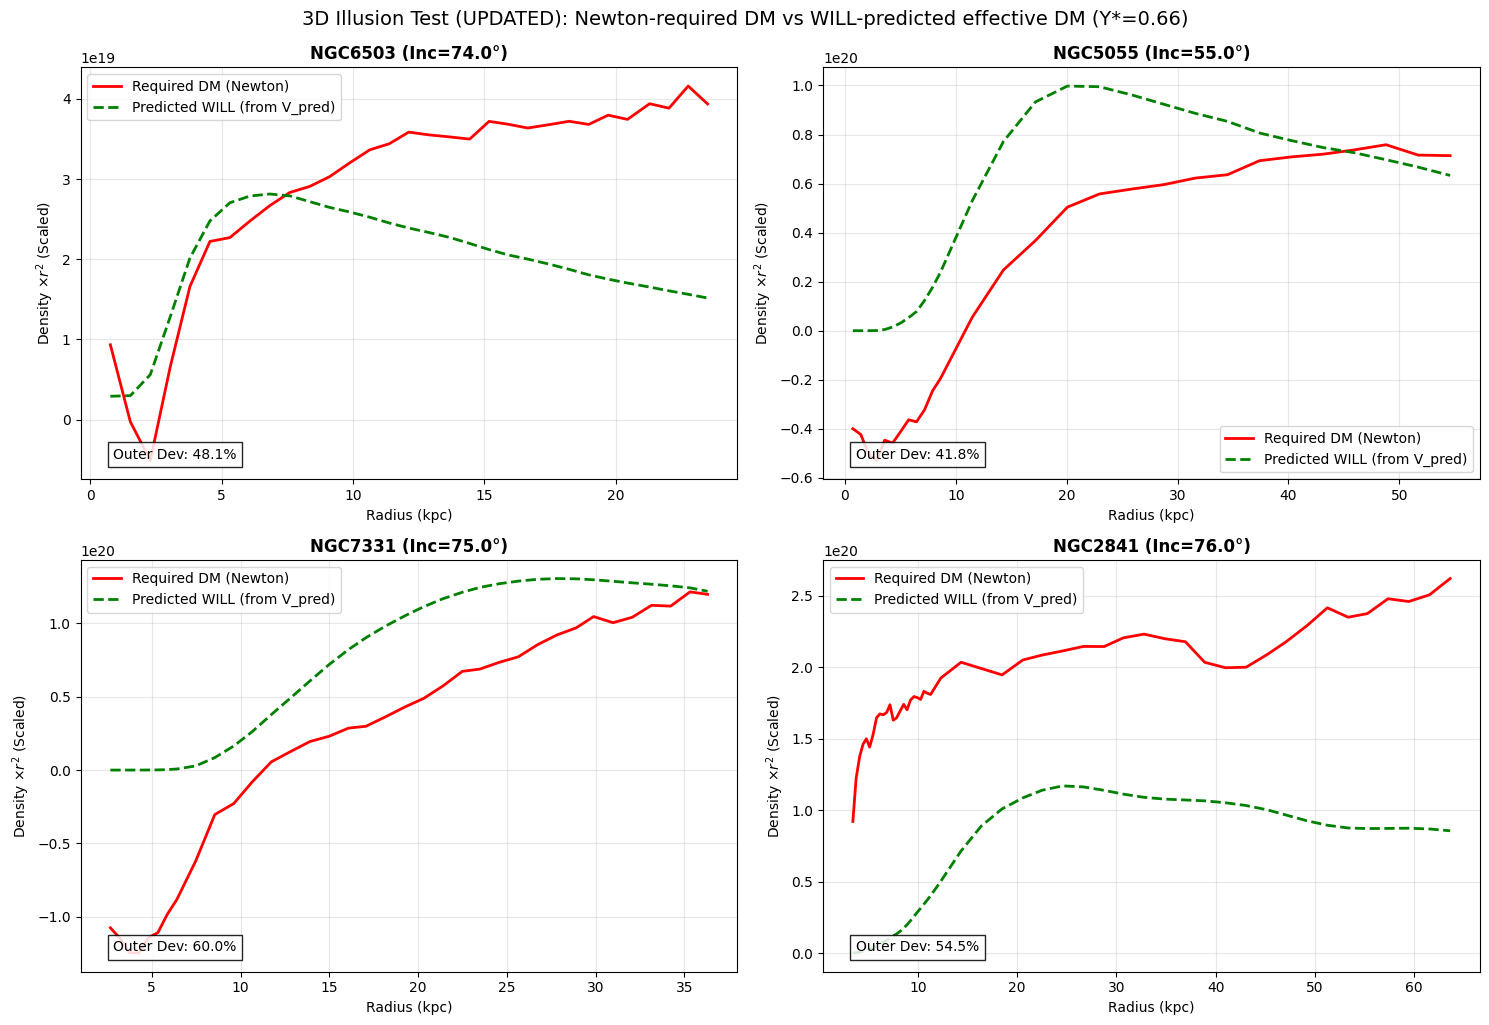

In [ ]:
# 3D Illusion Test (UPDATED):
# Compare "Required DM density (Newton)" vs "Effective DM density predicted by WILL"
# using:
#   rho_WILL(r) = 3/(4π G r^2) * (V_pred^2 - V_bar^2)
#   V_pred^2 = V_bar^2 * (1 + 2 exp[-Gamma])
#   Gamma = 3π * beta_bar^2 * (R_H / r),  beta_bar = V_bar / c

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# --- 1. CONFIGURATION ---
UPSILON_STAR = 0.66  # Y* (as you used in your plots)

# Cosmology (for R_H)
H0_km_s_Mpc = 65.5
MPC_TO_M = 3.085677581e22

# Physical constants (SI)
G = 6.67430e-11
c = 299792458.0
KPC_TO_M = 3.085677581e19

# URLs for SPARC Data (your repo mirror, same as your original code)
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Compute Hubble radius in meters
H0 = H0_km_s_Mpc * 1000.0 / MPC_TO_M  # s^-1
R_H = c / H0                          # meters
print(f"H0 = {H0_km_s_Mpc} km/s/Mpc  |  R_H = {R_H:.3e} m")

# --- 2. DATA LOADER ---
def load_sparc_data():
    print("--- DOWNLOADING SPARC DATA ---")

    # Table 1 (Properties): Name, Dist, Inc, L3.6
    print("Loading Table 1 (Properties).")
    try:
        response_t1 = requests.get(URL_T1)
        response_t1.raise_for_status()
        t1 = pd.read_fwf(
            io.BytesIO(response_t1.content),
            colspecs=[(0,11), (15,21), (30,34), (40,47)],
            header=None,
            names=['Name', 'Dist', 'Inc', 'L3.6']
        )
    except Exception as e:
        print(f"Error loading Table 1: {e}")
        return None, None

    # Table 2 (Rotation Curves): Name, Rad, Vobs, Vgas, Vdisk, Vbul
    print("Loading Table 2 (Rotation Curves).")
    try:
        response_t2 = requests.get(URL_T2)
        response_t2.raise_for_status()
        t2 = pd.read_fwf(
            io.BytesIO(response_t2.content),
            colspecs=[(0,11), (19,25), (26,32), (39,45), (46,52), (53,59)],
            header=None,
            names=['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        )
    except Exception as e:
        print(f"Error loading Table 2: {e}")
        return None, None

    # numeric conversion
    for col in ['Dist', 'Inc', 'L3.6']:
        t1[col] = pd.to_numeric(t1[col], errors='coerce')

    for col in ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']:
        t2[col] = pd.to_numeric(t2[col], errors='coerce')

    t1 = t1.dropna(subset=['Name', 'Inc'])
    t2 = t2.dropna(subset=['Name', 'Rad', 'Vobs'])
    t2 = t2[t2['Rad'] > 0].copy()

    print(f"Loaded {len(t1)} galaxies and {len(t2)} data points.")
    return t1, t2

# --- 3. PHYSICS ENGINE ---
def calculate_densities_updated(galaxy_name, t1, t2):
    # Properties
    gal_props = t1[t1['Name'] == galaxy_name].iloc[0]
    inc = float(gal_props['Inc'])

    # Rotation curve data
    gal_data = t2[t2['Name'] == galaxy_name].copy()
    gal_data = gal_data.sort_values('Rad')

    # 1) Units
    r_kpc = gal_data['Rad'].to_numpy(dtype=float)
    r_m = r_kpc * KPC_TO_M

    # Velocities in m/s (table2 gives km/s)
    V_obs = gal_data['Vobs'].to_numpy(dtype=float) * 1000.0
    V_gas = gal_data['Vgas'].to_numpy(dtype=float) * 1000.0
    V_disk = gal_data['Vdisk'].to_numpy(dtype=float) * 1000.0
    V_bul = gal_data['Vbul'].to_numpy(dtype=float) * 1000.0

    # 2) Baryonic velocity (your same convention: abs(V)*V keeps sign)
    V_bar_sq = (np.abs(V_gas) * V_gas) + \
               UPSILON_STAR * (np.abs(V_disk) * V_disk) + \
               UPSILON_STAR * (np.abs(V_bul) * V_bul)

    # avoid sqrt negatives
    V_bar_sq = np.maximum(V_bar_sq, 0.0)
    V_bar = np.sqrt(V_bar_sq)

    # 3) Required DM density (Newton): rho_DM_req = 3 (Vobs^2 - Vbar^2) / (4π G r^2)
    V_missing_sq = (V_obs**2 - V_bar_sq)
    rho_DM_required = (3.0 * V_missing_sq) / (4.0 * np.pi * G * r_m**2)

    # 4) WILL prediction for V_pred (NO Vobs here)
    # beta_bar = V_bar/c
    beta_bar = V_bar / c
    # Gamma = 3π beta_bar^2 * (R_H / r)
    # protect from r=0
    Gamma = 3.0 * np.pi * (beta_bar**2) * (R_H / np.maximum(r_m, 1e-30))

    V_pred_sq = V_bar_sq * (1.0 + 2.0 * np.exp(-Gamma))  # your formula
    # Effective DM density implied by WILL:
    rho_WILL = (3.0 * (V_pred_sq - V_bar_sq)) / (4.0 * np.pi * G * r_m**2)

    return r_kpc, rho_DM_required, rho_WILL, V_obs, V_bar, inc

def outer_deviation_percent(r_kpc, rho_req, rho_will, outer_fraction=0.5, eps=1e-30):
    """
    Mean relative deviation in the outer part of the curve.
    By default uses the outer half (like your original code).
    """
    n = len(r_kpc)
    if n < 6:
        return np.nan
    start = int((1.0 - outer_fraction) * n)
    rr = rho_req[start:]
    ww = rho_will[start:]

    # relative to required DM magnitude (more meaningful than dividing by rho_WILL)
    denom = np.maximum(np.abs(rr), eps)
    return float(np.mean(np.abs(rr - ww) / denom) * 100.0)

    check = (V_pred_sq - V_bar_sq) / (2.0 * V_bar_sq * np.exp(-Gamma) + 1e-30)
    print("check min/mean/max:", np.min(check), np.mean(check), np.max(check))


# --- 4. EXECUTION & PLOTTING ---
t1, t2 = load_sparc_data()

if t1 is not None and t2 is not None:
    # Choose galaxies (edit this list freely)
    sample_galaxies = ['NGC6503', 'NGC5055', 'NGC7331', 'NGC2841']
    # sample_galaxies = ['UGC04278', 'KK98-251', 'F563-1', 'DDO154']

    plt.figure(figsize=(15, 10))

    for i, gal_name in enumerate(sample_galaxies):
        if gal_name not in t1['Name'].values:
            print(f"Skipping {gal_name}: not in table1")
            continue

        r_kpc, rho_DM, rho_WILL, V_obs, V_bar, inc = calculate_densities_updated(gal_name, t1, t2)

        ax = plt.subplot(2, 2, i + 1)

        # Plot rho * r^2 to remove the 1/r^2 falloff (same as your original plot idea)
        r2 = (r_kpc * KPC_TO_M) ** 2

        ax.plot(r_kpc, rho_DM * r2, 'r-', linewidth=2, label='Required DM (Newton)')
        ax.plot(r_kpc, rho_WILL * r2, 'g--', linewidth=2, label='Predicted WILL (from V_pred)')

        dev = outer_deviation_percent(r_kpc, rho_DM, rho_WILL, outer_fraction=0.5)

        ax.set_title(f"{gal_name} (Inc={inc:.1f}°)", fontsize=12, fontweight='bold')
        ax.set_xlabel("Radius (kpc)")
        ax.set_ylabel(r"Density $\times r^2$ (Scaled)")
        ax.grid(True, alpha=0.3)
        ax.legend()

        if np.isfinite(dev):
            ax.text(
                0.05, 0.05, f"Outer Dev: {dev:.1f}%",
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.85)
            )

    plt.tight_layout()
    plt.suptitle(
        f"3D Illusion Test (UPDATED): Newton-required DM vs WILL-predicted effective DM (Y*={UPSILON_STAR})",
        fontsize=14, y=1.02
    )
    plt.show()

R_H = 4.577e+06 kpc  (H0=65.5)


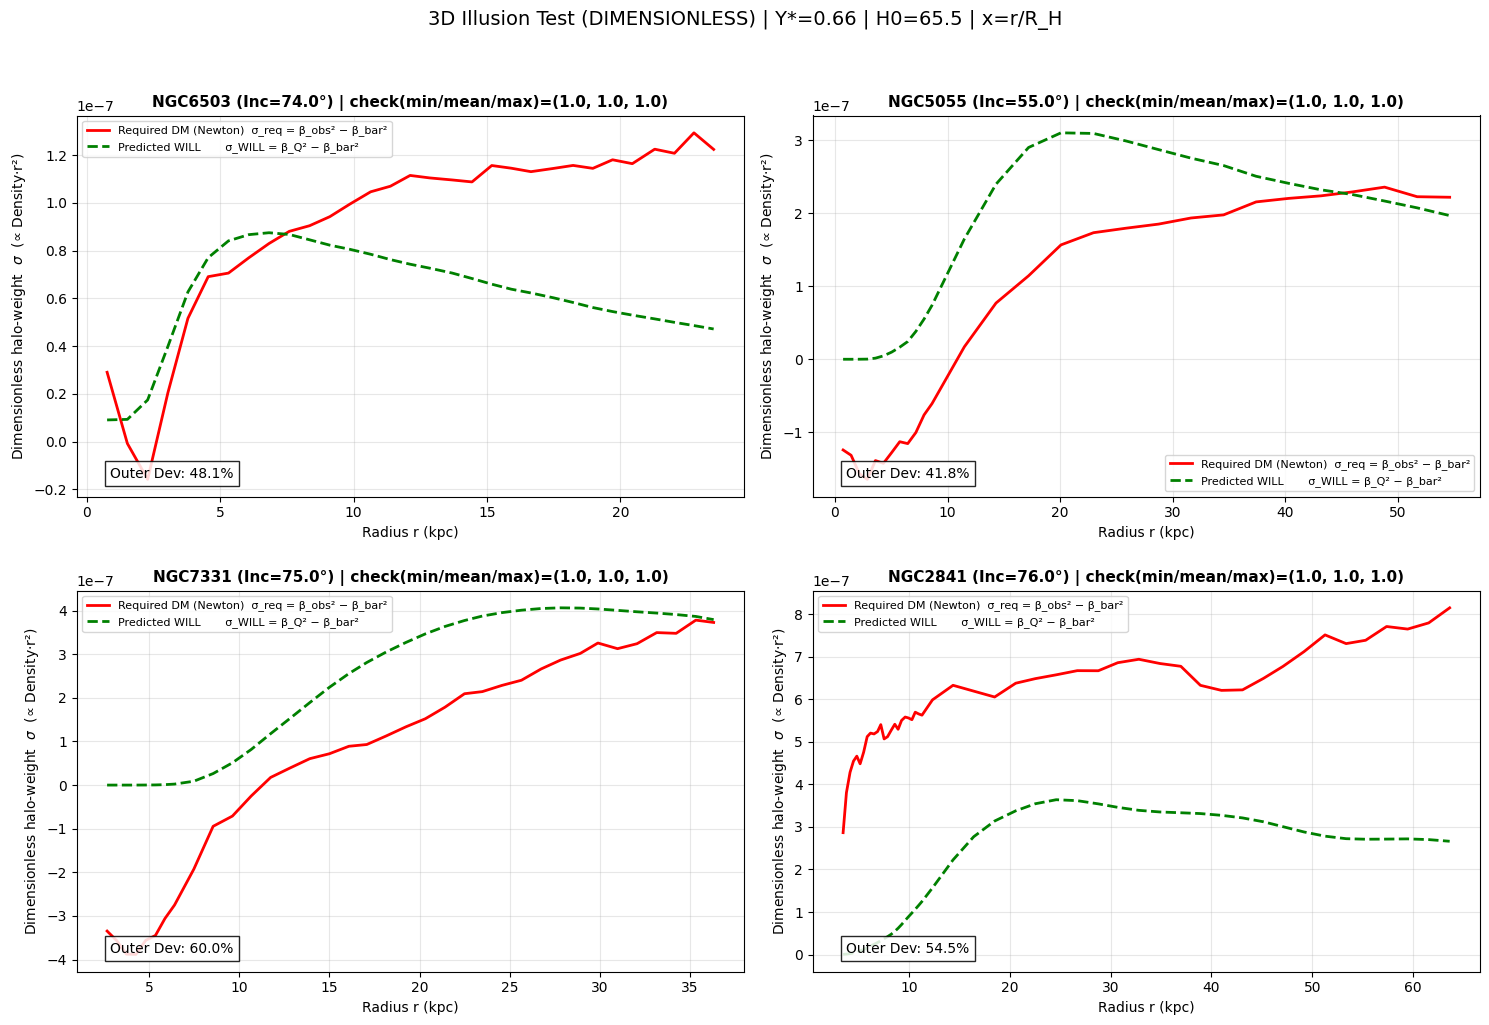

In [ ]:
# 3D Illusion Test (DIMENSIONLESS, UPDATED)
# Newton-required halo weight vs WILL-predicted halo weight
# using ONLY dimensionless variables: x=r/R_H and beta=V/c.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io

# -----------------------------
# SETTINGS (edit if needed)
# -----------------------------
Y_STAR = 0.66            # your chosen M/L (single value for disk+bulge in this simplified test)
H0 = 65.5                # km/s/Mpc
C_KMS = 299792.458       # km/s
OUTER_FRACTION = 0.50    # outer part used for "Outer Dev"
PLOT_X_AXIS = "r_kpc"    # "r_kpc" or "x" (dimensionless)

# Data sources (your repo mirror)
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Hubble radius in kpc
R_H_KPC = (C_KMS / H0) * 1000.0
print(f"R_H = {R_H_KPC:.3e} kpc  (H0={H0})")

# -----------------------------
# LOAD SPARC (same parsing style)
# -----------------------------
def load_sparc():
    # Table1: Name, Dist, Inc, L3.6
    r1 = requests.get(URL_T1); r1.raise_for_status()
    t1 = pd.read_fwf(
        io.BytesIO(r1.content),
        colspecs=[(0,11), (15,21), (30,34), (40,47)],
        header=None,
        names=["Name","Dist","Inc","L3.6"]
    )
    for c in ["Dist","Inc","L3.6"]:
        t1[c] = pd.to_numeric(t1[c], errors="coerce")
    t1 = t1.dropna(subset=["Name","Inc"])

    # Table2: Name, Rad, Vobs, e_Vobs, Vgas, Vdisk, Vbul  (we only need some cols)
    r2 = requests.get(URL_T2); r2.raise_for_status()
    t2 = pd.read_fwf(
        io.BytesIO(r2.content),
        colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)],
        header=None,
        names=["Name","Rad","Vobs","e_Vobs","Vgas","Vdisk","Vbul"]
    )
    for c in ["Rad","Vobs","Vgas","Vdisk","Vbul"]:
        t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name","Rad","Vobs"])
    t2 = t2[t2["Rad"] > 0].copy()

    return t1, t2

# -----------------------------
# CORE: compute dimensionless profiles for one galaxy
# -----------------------------
def galaxy_profiles_dimless(name, t1, t2, y_star=Y_STAR):
    # properties
    row = t1[t1["Name"] == name]
    if len(row) == 0:
        raise ValueError(f"{name} not in table1")
    inc = float(row.iloc[0]["Inc"])

    g = t2[t2["Name"] == name].copy()
    g = g.sort_values("Rad")
    if len(g) < 6:
        raise ValueError(f"{name}: too few points")

    r_kpc = g["Rad"].to_numpy(dtype=float)

    # velocities in km/s
    Vobs = g["Vobs"].to_numpy(dtype=float)
    Vgas = g["Vgas"].to_numpy(dtype=float)
    Vdisk = g["Vdisk"].to_numpy(dtype=float)
    Vbul  = g["Vbul"].to_numpy(dtype=float)

    # baryonic V^2 (keep your "abs(V)*V" convention)
    Vbar_sq = (np.abs(Vgas)  * Vgas) \
            + y_star * (np.abs(Vdisk) * Vdisk) \
            + y_star * (np.abs(Vbul)  * Vbul)

    Vbar_sq = np.maximum(Vbar_sq, 0.0)
    Vbar = np.sqrt(Vbar_sq)

    # basic quality mask (optional; keep light)
    m = (r_kpc > 0.5) & (Vbar > 20) & np.isfinite(Vobs) & np.isfinite(Vbar)
    r_kpc = r_kpc[m]
    Vobs  = Vobs[m]
    Vbar  = Vbar[m]
    Vbar_sq = Vbar_sq[m]

    if len(r_kpc) < 6:
        raise ValueError(f"{name}: too few points after mask")

    # dimensionless variables
    x = r_kpc / R_H_KPC
    beta_obs = (Vobs / C_KMS)
    beta_bar = (Vbar / C_KMS)

    # Gamma = 3π β_bar^2 * (R_H/r) = 3π β_bar^2 / x
    Gamma = 3.0 * np.pi * (beta_bar**2) / np.maximum(x, 1e-30)

    # WILL predicted beta_Q^2 = beta_bar^2(1 + 2 e^{-Gamma})
    beta_Q_sq = (beta_bar**2) * (1.0 + 2.0 * np.exp(-Gamma))

    # These are the key "halo weights" (dimensionless, proportional to your old "Density*r^2 (Scaled)")
    sigma_req  = (beta_obs**2) - (beta_bar**2)      # Newton-required missing
    sigma_will = (beta_Q_sq)   - (beta_bar**2)      # WILL-predicted missing (= 2 beta_bar^2 e^{-Gamma})

    # Optional sanity check: sigma_will should equal 2 beta_bar^2 e^{-Gamma}
    check = sigma_will / (2.0 * (beta_bar**2) * np.exp(-Gamma) + 1e-30)

    return {
        "name": name,
        "inc": inc,
        "r_kpc": r_kpc,
        "x": x,
        "sigma_req": sigma_req,
        "sigma_will": sigma_will,
        "check_min_mean_max": (float(np.min(check)), float(np.mean(check)), float(np.max(check))),
    }

def outer_dev_percent(r_axis, req, will, outer_fraction=OUTER_FRACTION):
    n = len(r_axis)
    start = int((1.0 - outer_fraction) * n)
    req_o = req[start:]
    wil_o = will[start:]

    # only compare where req is positive (otherwise ratio blows up)
    m = np.isfinite(req_o) & np.isfinite(wil_o) & (req_o > 0)
    if np.sum(m) < 3:
        return np.nan
    req_o = req_o[m]
    wil_o = wil_o[m]
    return float(np.mean(np.abs(req_o - wil_o) / np.maximum(np.abs(req_o), 1e-30)) * 100.0)

# -----------------------------
# RUN + PLOT
# -----------------------------
t1, t2 = load_sparc()

galaxies = ["NGC6503", "NGC5055", "NGC7331", "NGC2841"]  # edit list
# galaxies = ["UGC04278", "KK98-251", "F563-1", "DDO154"]

plt.figure(figsize=(15, 10))

for i, nm in enumerate(galaxies, start=1):
    try:
        res = galaxy_profiles_dimless(nm, t1, t2, y_star=Y_STAR)
    except Exception as e:
        print("skip", nm, ":", e)
        continue

    axis = res["r_kpc"] if PLOT_X_AXIS == "r_kpc" else res["x"]
    xlabel = "Radius r (kpc)" if PLOT_X_AXIS == "r_kpc" else r"Dimensionless radius $x=r/R_H$"

    dev = outer_dev_percent(axis, res["sigma_req"], res["sigma_will"])

    ax = plt.subplot(2, 2, i)
    ax.plot(axis, res["sigma_req"],  "r-",  lw=2, label="Required DM (Newton)  σ_req = β_obs² − β_bar²")
    ax.plot(axis, res["sigma_will"], "g--", lw=2, label="Predicted WILL       σ_WILL = β_Q² − β_bar²")

    ax.set_title(f"{nm} (Inc={res['inc']:.1f}°) | check(min/mean/max)={tuple(round(x,3) for x in res['check_min_mean_max'])}",
                 fontsize=11, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"Dimensionless halo-weight  $\sigma$  (∝ Density·r²)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc="best")

    if np.isfinite(dev):
        ax.text(0.05, 0.05, f"Outer Dev: {dev:.1f}%",
                transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.85))

plt.suptitle(f"3D Illusion Test (DIMENSIONLESS) | Y*={Y_STAR} | H0={H0} | x=r/R_H",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

R_H = 4.577e+06 kpc  (H0=65.5)


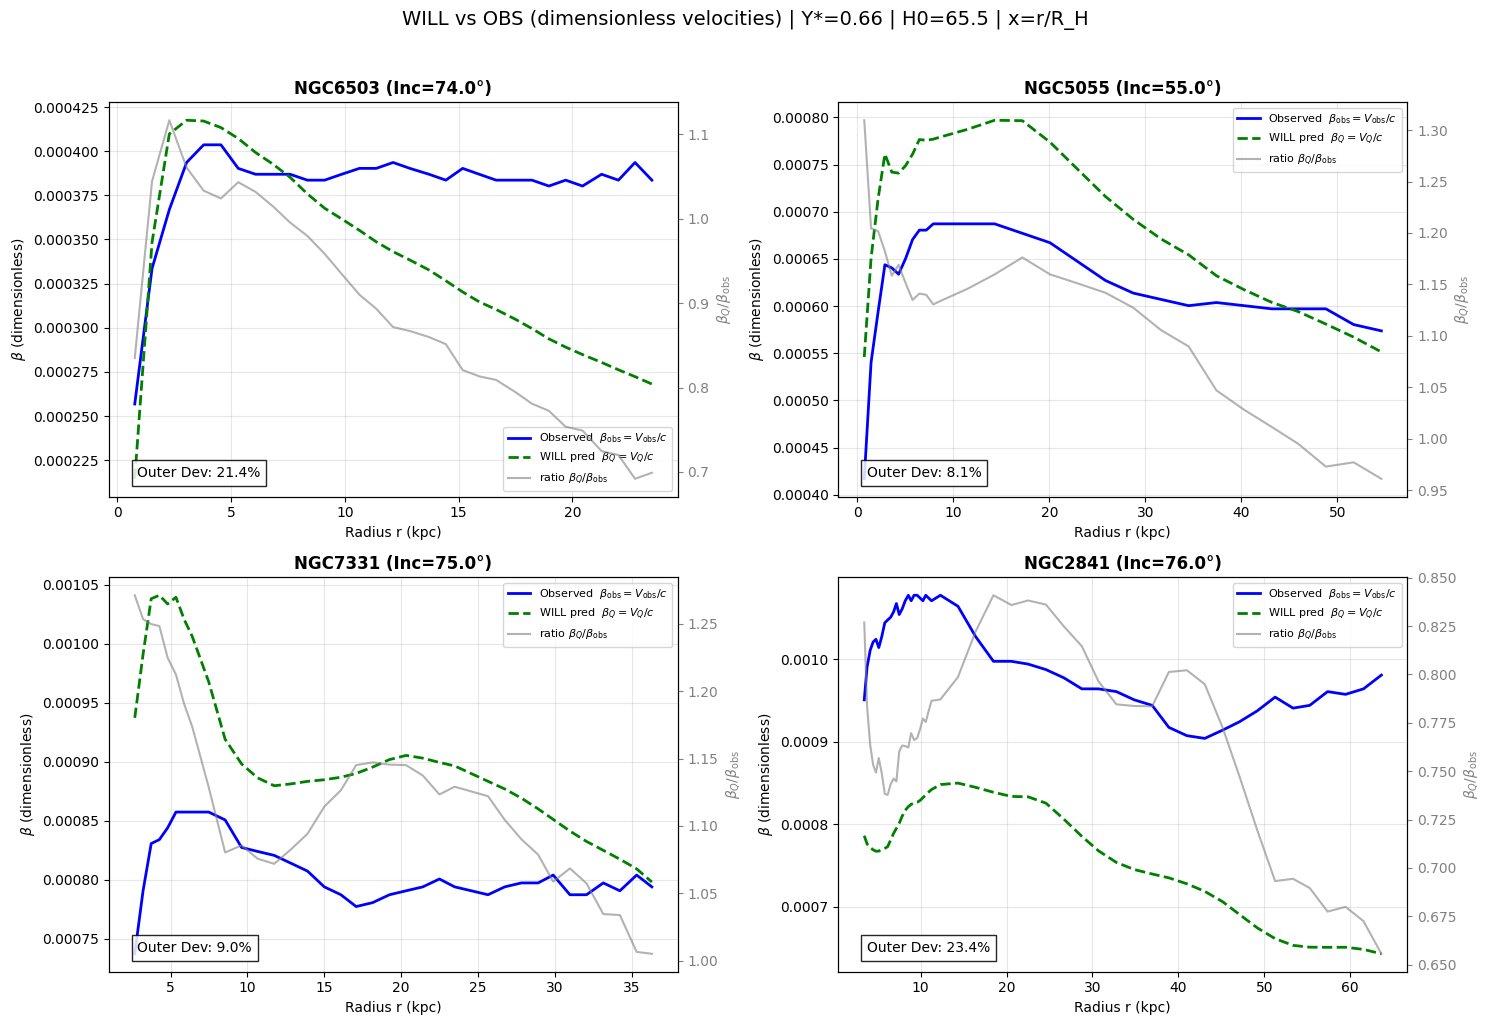

In [ ]:
# WILL vs OBS velocity test (DIMENSIONLESS)
# Compare beta_obs(r) = Vobs/c vs beta_pred(r) = V_Q/c
# using:
#   beta_Q^2 = beta_bar^2 * (1 + 2 exp(-Gamma))
#   Gamma = 3π beta_bar^2 * (R_H / r) = 3π beta_bar^2 / x,  x=r/R_H

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io

# -----------------------------
# SETTINGS
# -----------------------------
Y_STAR = 0.66          # M/L for disk+bulge (your choice)
H0 = 65.5              # km/s/Mpc
C_KMS = 299792.458     # km/s
OUTER_FRACTION = 0.50  # outer part used for "Outer Dev"
PLOT_X = "r_kpc"       # "r_kpc" or "x" (dimensionless)
APPLY_MASK = True      # keep your basic quality mask

# SPARC data (your repo mirror)
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# Hubble radius in kpc (same convention as before)
R_H_KPC = (C_KMS / H0) * 1000.0
print(f"R_H = {R_H_KPC:.3e} kpc  (H0={H0})")

# -----------------------------
# LOAD SPARC (same parsing style)
# -----------------------------
def load_sparc():
    r1 = requests.get(URL_T1); r1.raise_for_status()
    t1 = pd.read_fwf(
        io.BytesIO(r1.content),
        colspecs=[(0,11), (15,21), (30,34), (40,47)],
        header=None,
        names=["Name","Dist","Inc","L3.6"]
    )
    for c in ["Dist","Inc","L3.6"]:
        t1[c] = pd.to_numeric(t1[c], errors="coerce")
    t1 = t1.dropna(subset=["Name","Inc"])

    r2 = requests.get(URL_T2); r2.raise_for_status()
    t2 = pd.read_fwf(
        io.BytesIO(r2.content),
        colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)],
        header=None,
        names=["Name","Rad","Vobs","e_Vobs","Vgas","Vdisk","Vbul"]
    )
    for c in ["Rad","Vobs","Vgas","Vdisk","Vbul"]:
        t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name","Rad","Vobs"])
    t2 = t2[t2["Rad"] > 0].copy()
    return t1, t2

# -----------------------------
# CORE: one galaxy beta_obs vs beta_pred
# -----------------------------
def galaxy_beta_profiles(name, t1, t2, y_star=Y_STAR):
    row = t1[t1["Name"] == name]
    if len(row) == 0:
        raise ValueError(f"{name} not in table1")
    inc = float(row.iloc[0]["Inc"])

    g = t2[t2["Name"] == name].copy().sort_values("Rad")
    if len(g) < 6:
        raise ValueError(f"{name}: too few points")

    r_kpc = g["Rad"].to_numpy(dtype=float)

    # velocities in km/s
    Vobs = g["Vobs"].to_numpy(dtype=float)
    Vgas = g["Vgas"].to_numpy(dtype=float)
    Vdisk = g["Vdisk"].to_numpy(dtype=float)
    Vbul  = g["Vbul"].to_numpy(dtype=float)

    # baryonic V^2 (keep your abs(V)*V convention)
    Vbar_sq = (np.abs(Vgas) * Vgas) \
            + y_star * (np.abs(Vdisk) * Vdisk) \
            + y_star * (np.abs(Vbul)  * Vbul)
    Vbar_sq = np.maximum(Vbar_sq, 0.0)
    Vbar = np.sqrt(Vbar_sq)

    if APPLY_MASK:
        m = (r_kpc > 0.5) & (Vbar > 20) & np.isfinite(Vobs) & np.isfinite(Vbar)
        r_kpc = r_kpc[m]
        Vobs  = Vobs[m]
        Vbar  = Vbar[m]

    if len(r_kpc) < 6:
        raise ValueError(f"{name}: too few points after mask")

    # dimensionless
    x = r_kpc / R_H_KPC
    beta_obs = Vobs / C_KMS
    beta_bar = Vbar / C_KMS

    # Gamma = 3π β_bar^2 / x
    Gamma = 3.0 * np.pi * (beta_bar**2) / np.maximum(x, 1e-30)

    beta_pred_sq = (beta_bar**2) * (1.0 + 2.0 * np.exp(-Gamma))
    beta_pred = np.sqrt(np.maximum(beta_pred_sq, 0.0))

    # ratio for diagnostics (avoid div0)
    ratio = beta_pred / np.maximum(beta_obs, 1e-30)

    return {
        "name": name,
        "inc": inc,
        "r_kpc": r_kpc,
        "x": x,
        "beta_obs": beta_obs,
        "beta_pred": beta_pred,
        "ratio": ratio,
    }

def outer_dev_percent(axis, beta_obs, beta_pred, outer_fraction=OUTER_FRACTION):
    n = len(axis)
    start = int((1.0 - outer_fraction) * n)

    bo = beta_obs[start:]
    bp = beta_pred[start:]

    m = np.isfinite(bo) & np.isfinite(bp) & (bo > 0)
    if np.sum(m) < 3:
        return np.nan
    bo = bo[m]
    bp = bp[m]
    return float(np.mean(np.abs(bp - bo) / bo) * 100.0)

# -----------------------------
# RUN + PLOT
# -----------------------------
t1, t2 = load_sparc()

galaxies = ["NGC6503", "NGC5055", "NGC7331", "NGC2841"]  # edit list freely
# galaxies = ["UGC04278", "KK98-251", "F563-1", "DDO154"]

plt.figure(figsize=(15, 10))

for i, nm in enumerate(galaxies, start=1):
    try:
        res = galaxy_beta_profiles(nm, t1, t2, y_star=Y_STAR)
    except Exception as e:
        print("skip", nm, ":", e)
        continue

    axis = res["r_kpc"] if PLOT_X == "r_kpc" else res["x"]
    xlabel = "Radius r (kpc)" if PLOT_X == "r_kpc" else r"Dimensionless radius $x=r/R_H$"

    dev = outer_dev_percent(axis, res["beta_obs"], res["beta_pred"])

    ax = plt.subplot(2, 2, i)
    ax.plot(axis, res["beta_obs"],  "b-",  lw=2, label=r"Observed  $\beta_{\rm obs}=V_{\rm obs}/c$")
    ax.plot(axis, res["beta_pred"], "g--", lw=2, label=r"WILL pred  $\beta_Q=V_Q/c$")

    ax2 = ax.twinx()
    ax2.plot(axis, res["ratio"], color="gray", lw=1.5, alpha=0.6, label=r"ratio $\beta_Q/\beta_{\rm obs}$")
    ax2.set_ylabel(r"$\beta_Q/\beta_{\rm obs}$", color="gray")
    ax2.tick_params(axis='y', colors="gray")

    ax.set_title(f"{nm} (Inc={res['inc']:.1f}°)", fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$\beta$ (dimensionless)")
    ax.grid(True, alpha=0.3)

    # legend: combine both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, fontsize=8, loc="best")

    if np.isfinite(dev):
        ax.text(0.05, 0.05, f"Outer Dev: {dev:.1f}%",
                transform=ax.transAxes,
                bbox=dict(facecolor="white", alpha=0.85))

plt.suptitle(f"WILL vs OBS (dimensionless velocities) | Y*={Y_STAR} | H0={H0} | x=r/R_H",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()